## Install tf-gpu, imports e download dati, split train val

In [0]:
%tensorflow_version 1.x magic
from IPython.display import clear_output
!npm install -g localtunnel
%load_ext tensorboard
from google.colab import drive
drive.mount('/content/gdrive')  # Per scaricare i salvataggi
clear_output()

In [0]:
# tf ha come requisito che gast sia > 0.2, ma l'ultima versione di gast ha un 
# problema con autograph
!pip install gast==0.2.2
!pip install tensorflow-gpu==1.14


import os
from datetime import timedelta
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tf.logging.set_verbosity(tf.logging.ERROR)  # or any {DEBUG, INFO, WARN, ERROR, FATAL}

tfd = tfp.distributions

# Controllo della versione di tf, perché da 1/10 quella di default è la 2.0.0
print(tf.__version__)  
print(tf.test.gpu_device_name())  # Controllo se colab sta usando la gpu

# Download data
from keras.datasets import mnist
from scipy import io as spio
(x_train, y_train), (x_test, y_test) = mnist.load_data() # 60k - 10k


# Add a layer to represent colors, in RGB it will be 3, here it is 1 because 
# these are grayscale images. 
# The network needs 4 axes: Batches, height, width and layers
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

#clear_output()

     |████████████████████████████████| 377.0MB 44kB/s 
     |████████████████████████████████| 491kB 40.1MB/s 
     |████████████████████████████████| 3.2MB 48.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0
/device:GPU:0


Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def split_train_test(x, y, test_ratio):
  seed = np.random.RandomState(42)
  shuffled_indices  = seed.permutation(len(y))
  test_set_size = int(len(y) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  print(type(test_indices))
  return (x[train_indices], y[train_indices]), (x[test_indices], y[test_indices])

print(len(x_train))
(x_train, y_train), (x_val, y_val) = split_train_test(x_train, y_train, 0.15) 
print(len(x_train))

60000
<class 'numpy.ndarray'>
51000


## Parametri

In [0]:
learning_rate = default=0.0001  # Initial learning rate
epochs = 100  #Number of epochs to train for
batch_size = 1000  
eval_freq = 10*len(x_train)/batch_size  # validate the model every 10 epochs
valid_size = 1000
num_monte_carlo = 50  # Network draws to compute predictive probabilities

IMAGE_SHAPE = [28, 28, 1]


## Input pipeline

In [0]:
def make_generator(images, labels):

  def _generator():
    for image, label in zip(images, labels):
      yield image, label

  return _generator

def build_input_pipeline(x_train, x_test, y_train, y_test,
                         batch_size, valid_size):
    """Build an Iterator switching between train and heldout data."""
  
 
    # Since this is a small and simple dataset we load the entire set in one 
    # batch into the heldout set 

    # Converto in float 
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")

    x_train /= 255
    x_test /= 255

    print("x_train shape:" + str(x_train.shape))
    print(str(x_train.shape[0]) + " train samples")
    print(str(x_test.shape[0]) + " test samples")

    # Build an iterator over training batches.
    features_shape = [28, 28, 1]
    labels_shape = []

    training_dataset = tf.data.Dataset.from_generator(
        make_generator(x_train, np.int32(y_train)), (tf.float32, tf.int32), 
        (tf.TensorShape(features_shape), tf.TensorShape(labels_shape)))

    training_dataset = training_dataset.shuffle(
        len(x_train), reshuffle_each_iteration=True).repeat().batch(batch_size)
    training_iterator = tf.data.make_one_shot_iterator(training_dataset)

    # Build a iterator over the heldout set with batch_size=heldout_size,
    # i.e., return the entire heldout set as a constant.
  
    placeholder_X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    placeholder_y = tf.placeholder(tf.int32, [None])

    heldout_dataset = tf.data.Dataset.from_tensor_slices((placeholder_X, 
                                                          placeholder_y))

    heldout_batches = heldout_dataset.repeat().batch(valid_size)  # niente reshuffle
    heldout_iterator = tf.data.make_initializable_iterator(heldout_batches)

    # Combine these into a feedable iterator that can switch between training
    # and validation inputs.
    handle = tf.compat.v1.placeholder(tf.string, shape=[])
    feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(
        handle, training_dataset.output_types, training_dataset.output_shapes)
    images, labels = feedable_iterator.get_next()

    return images, labels, handle, training_iterator, heldout_iterator, placeholder_X, placeholder_y

## Main

In [0]:
from datetime import datetime
# Saves and logs Folder
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "/content/tf_logs"
logdir = "{}/run-{}/".format(root_logdir,now)
root_savedir = "/content/saves"

#Build the input pipeline
with tf.name_scope("Dataset"):
  (images, labels, handle,
  training_iterator,
  heldout_iterator, X, y) = build_input_pipeline(x_train, x_val, y_train, y_val, 
                                                 batch_size, valid_size)
  
#Build the network
with tf.name_scope("BNN"):
  inputs = tf.keras.layers.Input(shape=IMAGE_SHAPE, dtype='float32')
  x = tfp.layers.Convolution2DFlipout(32, (5, 5), activation='relu', padding='same')(inputs)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tfp.layers.Convolution2DFlipout(64, (5, 5), activation='relu', padding='same')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)

  x = tf.keras.layers.Flatten()(x)
  x = tfp.layers.DenseFlipout(100, activation='relu')(x)
  outputs = tfp.layers.DenseFlipout(10, activation=None)(x)
  model = tf.keras.Model(inputs, outputs)

logits = model(images)  #Network output before softmax
softmax = tf.nn.softmax(logits)  #Network output after softmax

with tf.name_scope("loss"):
  #Categorical distribution of probabilities for each instance
  labels_distribution = tfd.Categorical(logits=logits)    
  
  # Compute the -ELBO as the loss.

  log_likelihood = labels_distribution.log_prob(labels)  # Probability Mass Function (PMF) of each instance
  neg_log_likelihood = -tf.reduce_mean(input_tensor=log_likelihood)
  kl = sum(model.losses) / len(x_train) 
  loss = neg_log_likelihood + kl
  
# Build metrics for evaluation. Predictions are formed from a single forward
# pass of the probabilistic layers. They are cheap but noisy
# predictions.
predictions = tf.argmax(input=logits, axis=1)

with tf.name_scope("train"):
  train_accuracy, train_accuracy_update_op = tf.metrics.accuracy(
      labels=labels, predictions=predictions)
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
  train_op = optimizer.minimize(loss)

with tf.name_scope("valid"):
  valid_accuracy, valid_accuracy_update_op = tf.metrics.accuracy(
      labels=labels, predictions=predictions)

init_op = tf.group(tf.global_variables_initializer(),
                  tf.local_variables_initializer())  


loss_summary = tf.summary.scalar("loss", loss)
train_acc_summary = tf.summary.scalar("train_acc", train_accuracy)
valid_acc_summary = tf.summary.scalar("valid_acc", valid_accuracy)

file_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())  # save graph

stream_vars_train = [
    v for v in tf.local_variables() if "train/" in v.name]
reset_train_op = tf.compat.v1.variables_initializer(stream_vars_train)

stream_vars_valid = [
    v for v in tf.local_variables() if "valid/" in v.name]
reset_valid_op = tf.compat.v1.variables_initializer(stream_vars_valid)

saver = tf.train.Saver()  # save node


x_train shape:(51000, 28, 28, 1)
51000 train samples
9000 test samples


## Execution phase

In [0]:
with tf.Session() as sess:
    sess.run(init_op)

    # Run the training loop

    train_handle = sess.run(training_iterator.string_handle())
    heldout_handle = sess.run(heldout_iterator.string_handle())
    
    training_steps = int(
        round(epochs * (len(x_train) / batch_size))) #Epochs * step per epoch

    for step in range(training_steps):
        _ = sess.run([train_op, train_accuracy_update_op, update_step_op], 
                     feed_dict={handle: train_handle})

        #Compute, print and save accuracy every 100 steps

        if step % 100 == 0: 
            loss_value, accuracy_value, kl_value, summary_loss, \
            summary_t_acc = sess.run([loss, train_accuracy, kl, loss_summary, 
                                      train_acc_summary], 
                                     feed_dict={handle: train_handle})
            print(
                "Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f} KL: {:.3f}".format(
                    step, loss_value, accuracy_value, kl_value))
            file_writer.add_summary(summary_loss, step)
            file_writer.add_summary(summary_t_acc, step)
            sess.run(reset_train_op)

        #Save the model every 2000 steps
        if (step) % 2000 == 0:
            savedir = "{}/run-{}/".format(root_savedir,now)
            salvataggio = savedir + "bio.ckpt"

            if tf.io.gfile.exists(savedir):
                tf.compat.v1.logging.warning(
                    "Warning: deleting old log directory at {}".format(savedir))
                tf.io.gfile.rmtree(savedir)
                
            tf.io.gfile.makedirs(savedir)

            save_path = saver.save(sess, salvataggio)   


        #Validate the model and print and save the validation accuracy every 100 steps 
        if (step) % 100 == 0:

            for n in range(int(len(y_val)/valid_size)): #Validate using batches of valid_size
                sess.run(heldout_iterator.initializer, 
                         feed_dict = {handle: heldout_handle,
                                      X: x_val_norm[n*valid_size:(n+1)*valid_size,:,:,:],
                                      y: y_val[n*valid_size:(n+1)*valid_size]})
                
                sess.run(valid_accuracy_update_op, 
                         feed_dict={handle: heldout_handle})
                
                
            valid_value, summary_v_acc = sess.run([valid_accuracy, \
                                                   valid_acc_summary], 
                                                  feed_dict={handle: heldout_handle})
            
            print(" ... Validation Accuracy: {:.3f}".format(valid_value))
            file_writer.add_summary(summary_v_acc, step)
            sess.run(reset_valid_op)

file_writer.close()

## Tensorboard

In [0]:
#Display tensorboard
%tensorboard --logdir "/content/gdrive/My Drive/BIOINFORMATICS - Project 7.1/MNIST/BNN MNIST/tf_logs/" --port 8008 --reload_interval 2


## emnist

In [0]:
# Download EMNIST dataset
!wget http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
!unzip matlab.zip
emnist = spio.loadmat(os.path.join("matlab", "emnist-letters"))

--2020-02-18 14:00:04--  http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 129.6.13.51, 2610:20:6b01:4::36
Connecting to www.itl.nist.gov (www.itl.nist.gov)|129.6.13.51|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip [following]
--2020-02-18 14:00:04--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
Connecting to www.itl.nist.gov (www.itl.nist.gov)|129.6.13.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743900280 (709M) [application/zip]
Saving to: ‘matlab.zip’

matlab.zip          100%[===================>] 709.44M  47.8MB/s    in 16s     

2020-02-18 14:00:21 (43.3 MB/s) - ‘matlab.zip’ saved [743900280/743900280]

Archive:  matlab.zip
  inflating: matlab/emnist-balanced.mat  
  inflating: matlab/emnist-byclass.mat  
  inflating: matlab/emnist-bymerge.mat  
  inflating: matlab/emnis

In [0]:
x_train2 = emnist["dataset"][0][0][0][0][0][0]
x_train2 = np.squeeze(x_train2.astype(np.float32))
y_train2 = np.squeeze(emnist["dataset"][0][0][0][0][0][1])
x_test2 = emnist["dataset"][0][0][1][0][0][0]
x_test2 = x_test2.astype(np.float32)
y_test2 = np.squeeze(emnist["dataset"][0][0][1][0][0][1])
x_train2 /= 255
x_test2 /= 255
x_train2 = x_train2.reshape(x_train2.shape[0], 28, 28, order="A")
x_test2 = x_test2.reshape(x_test2.shape[0], 28, 28, order="A")

x_val2 = np.expand_dims(x_test2, axis=3) 
fake_labels = np.zeros((len(x_test2), 10))

A


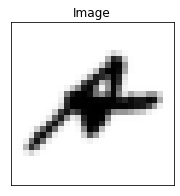

In [0]:
n_emnist=205

print(chr(y_test2[n_emnist]+64))
plt.figure(figsize=(5, 3))
img=plt.imshow(np.squeeze(x_test2[n_emnist]), cmap='Greys')
plt.title('Image')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [0]:
#Function which computes uncertainty
def compute_uncertainty(x,label,valid_size):
    with tf.Session() as sess:
        #Restore trained model
        sess.run(init_op)
        saver.restore(sess,"/content/gdrive/My Drive/BIOINFORMATICS - Project 7.1/MNIST/BNN MNIST/tf_saves/mnist.ckpt")
        sess.run(reset_valid_op)

        num_monte_carlo = 50 #Number of inferences
        threshold = 0.15 #Images with uncertainty > threshold are considered uncertain
        
        #Lists used to store data about all the images. In particular:
        aleatoric_def = [] #Stores aleatoric uncertainty
        epistemic_def = [] #Stores epistemic uncertainty
        wrong = [] #Stores index of wrong predictions
        predicted_as = [] #Stores the prediction label (not always correct)

        counter = [0,0,0,0] #right, wrong, skipped right, skipped wrong

        heldout_handle = sess.run(heldout_iterator.string_handle())

        for n in range(int(len(label)/valid_size)): #For each batch of valid_size
            sess.run(heldout_iterator.initializer, 
                        feed_dict = {handle: heldout_handle,
                                    X: x[n*valid_size:(n+1)*valid_size,:,:,:],
                                    y: label[n*valid_size:(n+1)*valid_size]})

            sess.run(valid_accuracy_update_op, 
                        feed_dict={handle: heldout_handle})
            
            #Uncertainty computation
            probs = np.asarray([sess.run(labels_distribution.probs,
                                feed_dict={handle: heldout_handle})
                        for _ in range(num_monte_carlo)])
            
            # probs has dimensions: [num_montecarlo, valid_size, num_classes]

            for i in range(valid_size): #For each image in the current batch:
                predicted_class = np.argmax(np.mean(probs[:,i,:],axis=0)) #Class with highest probability
                if predicted_class != label[n*valid_size+i]:
                    wrong.append(n*valid_size + i)  #Wrong prediction

                phat = probs[:,i,:] #dimensions: [num_monte_carlo, num_classes]
                psigned = np.mean(probs[:,i,:],axis=0) #dimensions: [num_classes]

                aleatoric = 0
                epistemic = 0
                for t in range(num_monte_carlo): #For each inference
                    aleatoric += phat[t,predicted_class] - (phat[t,predicted_class])**2 #Compute aleatoric uncertainty
                    epistemic += (phat[t,predicted_class] - psigned[predicted_class])**2 #Compute epistemic uncertainty
                aleatoric/=num_monte_carlo #Mean aleatoric uncertainty over num_monte_carlo inferences
                epistemic/=num_monte_carlo #Mean epistemic uncertainty over num_monte_carlo inferences
 
                aleatoric_def.append(aleatoric)
                epistemic_def.append(epistemic)
                predicted_as.append(predicted_class)

                #Update variables to print new accuracies
                if aleatoric+epistemic > threshold: #Uncertain
                  if predicted_class == label[n*valid_size+i]: #Uncertain but it was right
                    counter[2]+=1
                  else: #Uncertain and it was wrong
                    counter[3]+=1
                elif predicted_class == label[n*valid_size+i]:  #Not uncertain and right prediction
                  counter[0]+=1
                else: #Not uncertain and wrong prediction
                  counter[1]+=1
                  
        valid_value = sess.run(valid_accuracy, feed_dict={handle: heldout_handle})

        print(" ... Validation Accuracy: {:.3f}".format(valid_value))
        print("Right predicted: {:.2f}% , Wrong predicted: {:.2f}% , Unpredicted : {:.2f}%".format(100*(counter[0]/sum(counter)),100*(counter[1]/sum(counter)),100*((counter[2]+counter[3])/sum(counter))))
        print("Right unpredicted {:.2f}%, wrong unpredicted {:.2f}%".format(100*counter[2]/(counter[2]+counter[3]),100*counter[3]/(counter[2]+counter[3])))
        print("Accuracy on predicted: {:.2f}%".format(100*(counter[0]/(counter[0]+counter[1]))))
        sess.run(reset_valid_op)

    return np.array(aleatoric_def), np.array(epistemic_def), np.array(predicted_as), np.array(wrong)

In [0]:
def show_uncertainty(index, x, y, aleatoric, epistemic, predicted_as, isEmnist=True):
    
    if isEmnist:
        label = chr(y[index]+64)
    else:
        label = y[index]

    print(label, " predicted as ", predicted_as[index], "with uncertainty %.2f%%"%(100*(aleatoric[index]+ epistemic[index])))
    print("Aleatoric: %.2f%%\tEpistemic: %.2f%%"%(100*aleatoric[index],100*epistemic[index]))

    plt.figure(figsize=(5, 3))
    img=plt.imshow(np.squeeze(x[index]), cmap='Greys')
    plt.title('Image')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [0]:
isEmnist = False

if isEmnist:
    x_load = x_val2 
    y_load = y_test2
else:
    x_load = x_test
    x_load.astype(np.float32)
    x_load = x_load/255
    y_load = y_test

In [0]:
aleatoric, epistemic, predicted_as, wrong = compute_uncertainty(x_load, y_load, valid_size)

 ... Validation Accuracy: 0.986
Right predicted: 97.34% , Wrong predicted: 0.07% , Unpredicted : 2.59%
Right unpredicted 77.99%, wrong unpredicted 22.01%
Accuracy on predicted: 99.93%


In [0]:
print(wrong)  # wrong predictions

[ 340  582  619  674  740  813  947 1014 1112 1182 1226 1242 1247 1393
 1530 1709 1878 1901 2035 2043 2118 2129 2130 2135 2182 2293 2387 2414
 2454 2462 2488 2597 2654 2896 2939 2995 3073 3225 3422 3503 3520 3558
 3727 3762 3767 3806 3808 3893 4176 4224 4256 4536 4740 4761 4823 5654
 5937 5955 5973 6572 6576 6597 6651 6783 7216 8325 8408 9009 9530 9664
 9729 9770]


5  predicted as  3 with uncertainty 16.02%
Aleatoric: 6.50%	Epistemic: 9.52%


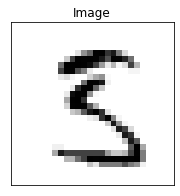

In [0]:
show_uncertainty(2597, x_load, y_load, aleatoric, epistemic, predicted_as, isEmnist)

In [0]:
# Unpredicted images

unpredicted = (aleatoric + epistemic) > 0.15
(np.where(unpredicted))

(array([  62,   92,  151,  247,  320,  340,  359,  445,  448,  449,  495,
         551,  582,  583,  619,  625,  659,  674,  684,  691,  716,  717,
         720,  740,  882,  900,  938,  947,  965, 1014, 1039, 1044, 1107,
        1112, 1182, 1226, 1232, 1242, 1247, 1260, 1299, 1319, 1326, 1364,
        1393, 1403, 1414, 1500, 1522, 1527, 1530, 1549, 1553, 1554, 1559,
        1601, 1621, 1681, 1709, 1737, 1790, 1828, 1868, 1878, 1900, 1954,
        1955, 1982, 2001, 2018, 2035, 2043, 2070, 2098, 2109, 2118, 2129,
        2135, 2182, 2185, 2224, 2266, 2293, 2329, 2343, 2369, 2387, 2406,
        2414, 2454, 2462, 2488, 2582, 2607, 2648, 2659, 2720, 2742, 2769,
        2770, 2771, 2810, 2896, 2921, 2927, 2939, 2953, 2959, 2995, 3005,
        3060, 3073, 3100, 3225, 3289, 3330, 3422, 3441, 3451, 3475, 3503,
        3534, 3558, 3597, 3601, 3662, 3702, 3727, 3751, 3762, 3767, 3778,
        3780, 3806, 3838, 3850, 3853, 3869, 3893, 3906, 3926, 3941, 3951,
        3985, 4007, 4027, 4078, 4163, 